In [1]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge
from scipy.stats import norm
from tqdm import tqdm
from sklearn.metrics import r2_score

In [2]:
#reading 'development' dataset
data = pd.read_csv("dev.tsv", sep="\t", low_memory = False)
data.head(2)

,country,description,designation,province,region_1,region_2,variety,winery,quality
0,France,"A creamed pear wine, with an attractive tang o...",Brut Blanc de Blancs,Alsace,Crémant d'Alsace,NaN,Pinot Blanc,Lucien Albrecht,45.0
1,US,"Simple and dry, this Cabernet has modest black...",NaN,California,Paso Robles,Central Coast,Cabernet Sauvignon,Castle Rock,31.0


In [3]:
#print number of rows and columns
print("Data has {} rows and {} columns".format(data.shape[0], data.shape[1]))

Data has 120744 rows and 9 columns


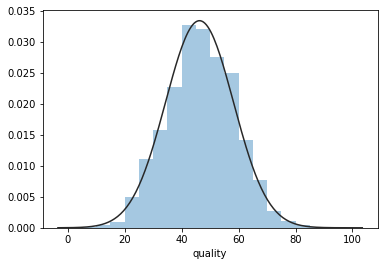

In [4]:
#Quality look to be nicely distributed from 20 to 80 points
distribution = sns.distplot(data.quality, bins = 20, kde = False, fit = norm)

In [5]:
#fig = distribution.get_figure()
#fig.savefig(fname ="C:/Users/xferm/Desktop/Data Science Lab-2020/distribution.png", format='png', dpi=300)

In [6]:
print("Proportion of Null Values in Each Column")
print(np.around(data.isna().sum()/data.shape[0]*100, 3))
NAlist = np.around(data.isna().sum()/data.shape[0], 4).values*100

na_country = np.array([NAlist[0], 100- NAlist[0]])
na_description = np.array([NAlist[1], 100- NAlist[1]])
na_designation = np.array([NAlist[2], 100- NAlist[2]])

na_province = np.array([NAlist[3], 100- NAlist[3]])
na_region_1 = np.array([NAlist[4], 100- NAlist[4]])
na_region_2 = np.array([NAlist[5], 100- NAlist[5]])

na_variety = np.array([NAlist[6], 100- NAlist[6]])
na_winery = np.array([NAlist[7], 100- NAlist[7]])

na_quality = np.array([NAlist[8], 100- NAlist[8]])

NA_pairs_list = [na_country, na_description, na_designation, na_province, na_region_1, \
                 na_region_2, na_variety, na_winery, na_quality]

Proportion of Null Values in Each Column
country         0.004
description     0.000
designation    30.244
province        0.004
region_1       16.571
region_2       59.637
variety         0.000
winery          0.000
quality         0.000
dtype: float64


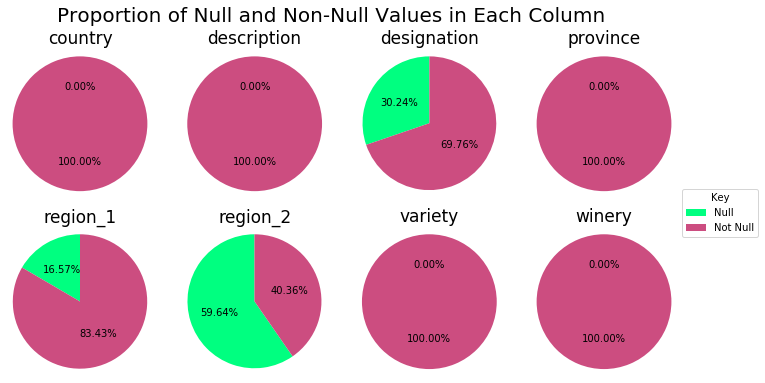

In [7]:
fig, axes= plt.subplots(2, 4)
fig.set_size_inches(12,6)
fig.suptitle("Proportion of Null and Non-Null Values in Each Column", fontsize=20)
for i, ax in enumerate(axes.flatten()):
    ax.pie(NA_pairs_list[i], autopct="%.2f%%", pctdistance=0.55,  \
           radius = 3,startangle=90, colors = [[0,1, 0.5], [0.8, 0.3, 0.5]]) #, wedgeprops = {'edgecolor':'black'})
    ax.set_title(data.columns[i], fontsize = 17)
    ax.axis('equal')
ax.legend(['Null', 'Not Null'],
          title="Key",
          loc="center left",
          bbox_to_anchor=(1, 0.6, 0.4, 1))

plt.show()

In [8]:
#fig.savefig(fname ="C:/Users/xferm/Desktop/Data Science Lab-2020/null_final.png", format='png', dpi=300)

In [9]:
#From the proportion of NUll values we saw that there are so few rows which do not have 'country' or 'province', that is why,
#it is better to remove particular rows.
data.dropna(subset = ['country', 'province'], inplace = True)

In [10]:
#For filling the missing values of 'region_1' we will iterate through all the province values and write to dictionary 
#the most seen 'region_1' value along with particular province name. If there is not even single region for particular province 
#(and this is often the case) then write 'NoListedRegion'.
#For instance, we will find most seen 'region_1' for Italy and write both of them as key, values pair.
regionDict = {}
for p in data.province.value_counts().index:
    if len(data[data.province ==p].region_1.value_counts()) < 1:
        regionDict.update({p: 'NoListedRegion'})
    else:
        regionDict.update({p:  data[data.province == p].region_1.value_counts().index[0]})

In [11]:
#Filling Null values in 'region_1' by looking up the associated province and
#finding the most common region for that province in the regionDict
tqdm.pandas()
data['region_1_filled'] = data[['province', 'region_1']].progress_apply(lambda row: row.fillna(value = \
regionDict.get(row['province'])), axis = 1).loc[:, 'region_1']

100%|██████████| 120739/120739 [00:57<00:00, 2102.50it/s]


In [12]:
#Same process repeated this time for 'designation'
designationDict = {}
for p in data.winery.value_counts().index:
    if len(data[data.winery ==p].designation.value_counts()) < 1:
        designationDict.update({p: 'NoListedDesignation'})
    else:
        designationDict.update({p:  data[data.winery == p].designation.value_counts().index[0]})

In [13]:
data['designation_filled'] = data[['winery', 'designation']].progress_apply(lambda row: row.fillna(value = \
designationDict.get(row['winery'])), axis = 1).loc[:, 'designation'] 

100%|██████████| 120739/120739 [00:57<00:00, 2088.85it/s]


In [14]:
data.isna().sum()

country                   0
description               0
designation           36518
province                  0
region_1              20003
region_2              72003
variety                   0
winery                    0
quality                   0
region_1_filled           0
designation_filled        0
dtype: int64

In [15]:
#Loop through cateorical variables and print number of distinct values and append proportion of distinct values to a list
data_cats = data.columns[data.dtypes.values=="O"]
uniqueList = []
for c in data_cats:
    print("{} has {} distinct values, {}% of values unique".format(c, len(data[c].value_counts()), \
    np.around(len(data[c].value_counts())/data.shape[0]*100,2)))
    uniqueList.append(np.around(len(data[c].value_counts())/data.shape[0]*100,2))

country has 48 distinct values, 0.04% of values unique
description has 85002 distinct values, 70.4% of values unique
designation has 27797 distinct values, 23.02% of values unique
province has 444 distinct values, 0.37% of values unique
region_1 has 1206 distinct values, 1.0% of values unique
region_2 has 18 distinct values, 0.01% of values unique
variety has 603 distinct values, 0.5% of values unique
winery has 14104 distinct values, 11.68% of values unique
region_1_filled has 1207 distinct values, 1.0% of values unique
designation_filled has 27798 distinct values, 23.02% of values unique


In [16]:
uni_country = np.array([uniqueList[0], 100- uniqueList[0]])
uni_description = np.array([uniqueList[1], 100- uniqueList[1]])

uni_designation = np.array([uniqueList[2], 100- uniqueList[2]])
uni_province = np.array([uniqueList[3], 100- uniqueList[3]])

uni_region_1 = np.array([uniqueList[4], 100- uniqueList[4]])
uni_region_2 = np.array([uniqueList[5], 100- uniqueList[5]])

uni_variety = np.array([uniqueList[6], 100- uniqueList[6]])
uni_winery = np.array([uniqueList[7], 100- uniqueList[7]])

unique_pairs_list = [uni_country, uni_description, uni_designation, uni_province, uni_region_1, uni_region_2, \
                     uni_variety, uni_winery]

labels = ('Unique', 'Non-Unique')

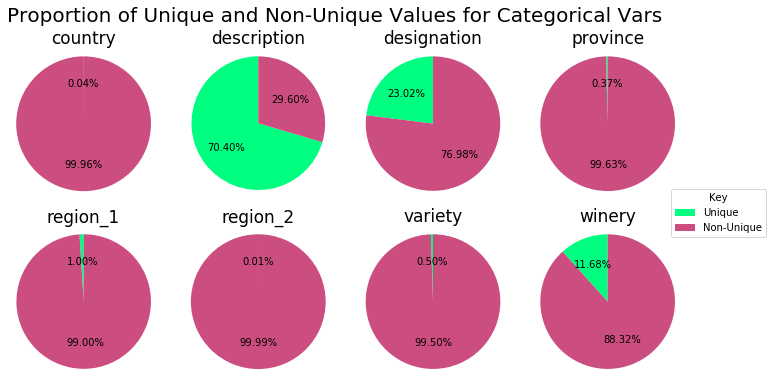

In [17]:
fig, axes= plt.subplots(2, 4)
fig.set_size_inches(12,6)
fig.suptitle("Proportion of Unique and Non-Unique Values for Categorical Vars", fontsize=20)
for i, ax in enumerate(axes.flatten()):
    ax.pie(unique_pairs_list[i], autopct="%.2f%%", pctdistance=0.6, \
    radius = 2,startangle=90, colors = [[0,1, 0.5], [0.8, 0.3, 0.5]])
    ax.set_title(data_cats[i], fontsize = 17 )
    ax.axis('equal')
    
ax.legend(labels,
          title="Key",
          loc="center left",
          bbox_to_anchor=(0.9, 0.6, 0.4, 1))
plt.show()

In [18]:
#fig.savefig(fname ="C:/Users/xferm/Desktop/Data Science Lab-2020/unique_final.png", format='png', dpi=300)

In [19]:
#Checking the rows that have the same 'description', 'winery', 'variety', 'country' and 'province'
data[(data.duplicated(subset = ['description', 'winery', 'variety','country', 'province']))] \
.sort_values(by = 'description').head()

,country,description,designation,province,region_1,region_2,variety,winery,quality,region_1_filled,designation_filled
94890,Chile,$11. Opens with a highly perfumed bouquet of l...,Estate Reserve,Maipo Valley,NaN,NaN,Chardonnay,La Playa,29.0,NoListedRegion,Estate Reserve
23306,Austria,". Christoph Neumeister's top wine, this is a c...",Moarfeitl,Südoststeiermark,NaN,NaN,Sauvignon Blanc,Neumeister,57.0,NoListedRegion,Moarfeitl
27170,Austria,". Christoph Neumeister's top wine, this is a c...",Moarfeitl,Südoststeiermark,NaN,NaN,Sauvignon Blanc,Neumeister,57.0,NoListedRegion,Moarfeitl
97820,France,. From a small south-facing parcel next to the...,Trie Spéciale,Loire Valley,Savennières,NaN,Chenin Blanc,Domaine des Baumard,54.0,Savennières,Trie Spéciale
78567,Argentina,". Pencil eraser, tomato leaf and sweet fruit a...",NaN,Mendoza Province,Mendoza,NaN,Cabernet Sauvignon,Fantelli,24.0,Mendoza,Serie Magno


In [20]:
data.shape

(120739, 11)

In [21]:
#Drop the rows that have the same 'description', 'winery', 'variety', 'country', and 'province'
data.drop_duplicates(subset = ['description', 'winery', 'variety', 'country', 'province'],inplace = True)

In [22]:
#We can easily see there are more that 35k duplicates.
data.shape

(85018, 11)

In [23]:
#Drop all rows that have a '-' in the country column,
#no countries have a dash in their name but some values in the data set did ('US-France')
data = data[~(data.country.astype(str).str.contains('-'))].reset_index(drop=True)

In [24]:
#Final uniqueness version categorical variables
uniqueList2 = []
for c in data_cats:
    print("{} has {} distinct values, {}% of values unique".format(c, len(data[c].value_counts()), \
    np.around(len(data[c].value_counts())/data.shape[0]*100,2)))
    uniqueList2.append(np.around(len(data[c].value_counts())/data.shape[0]*100,2))

country has 47 distinct values, 0.06% of values unique
description has 85001 distinct values, 99.98% of values unique
designation has 27795 distinct values, 32.69% of values unique
province has 443 distinct values, 0.52% of values unique
region_1 has 1206 distinct values, 1.42% of values unique
region_2 has 18 distinct values, 0.02% of values unique
variety has 603 distinct values, 0.71% of values unique
winery has 14103 distinct values, 16.59% of values unique
region_1_filled has 1207 distinct values, 1.42% of values unique
designation_filled has 27796 distinct values, 32.69% of values unique


In [25]:
_uni_country = np.array([uniqueList2[0], 100- uniqueList2[0]])
_uni_description = np.array([uniqueList2[1], 100- uniqueList2[1]])

_uni_designation = np.array([uniqueList2[2], 100- uniqueList2[2]])
_uni_province = np.array([uniqueList2[3], 100- uniqueList2[3]])

_uni_region_1 = np.array([uniqueList2[4], 100- uniqueList2[4]])
_uni_region_2 = np.array([uniqueList2[5], 100- uniqueList2[5]])

_uni_variety = np.array([uniqueList2[6], 100- uniqueList2[6]])
_uni_winery = np.array([uniqueList2[7], 100- uniqueList2[7]])

uni_pairs_list2 = [_uni_country, _uni_description, _uni_designation, _uni_province, _uni_region_1, _uni_region_2, _uni_variety, _uni_winery]

labels = ('Unique', 'Non-Unique')
colors = ['orange', 'red']

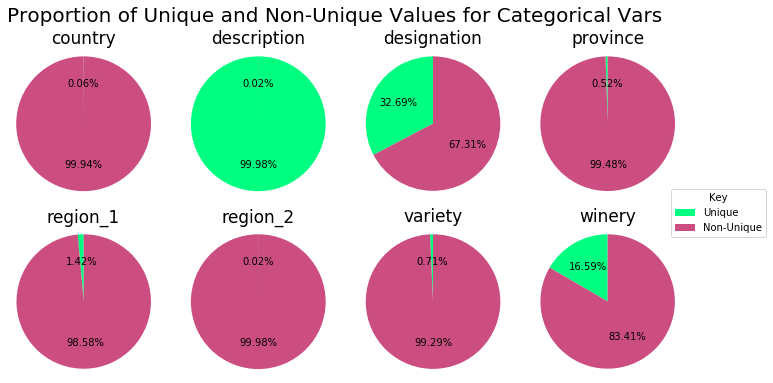

In [26]:
fig, axes= plt.subplots(2, 4)
fig.set_size_inches(12,6)
fig.suptitle("Proportion of Unique and Non-Unique Values for Categorical Vars", fontsize=20)
for i, ax in enumerate(axes.flatten()):
    ax.pie(uni_pairs_list2[i], autopct="%.2f%%", pctdistance=0.6, \
    radius = 2,startangle=90, colors = [[0,1, 0.5], [0.8, 0.3, 0.5]])
    ax.set_title(data_cats[i], fontsize = 17)
    ax.axis('equal')
    
ax.legend(labels,
          title="Key",
          loc="center left",
          bbox_to_anchor=(0.9, 0.6, 0, 1))
plt.show()

In [27]:
#fig.savefig(fname ="C:/Users/xferm/Desktop/Data Science Lab-2020/final.png", format='png', dpi=300)

In [28]:
#'development' dataset for training regression
X_dev = data.drop(['designation', 'region_1', 'region_2', 'quality'], axis =1) 
y_dev = data['quality']

In [29]:
#Reading Evaluation data
data_eval = pd.read_csv("eval.tsv", sep="\t", low_memory = False)

In [30]:
#Soving Null problem of 'region_1'
regionDict = {}
for p in data_eval.province.value_counts().index:
    if len(data_eval[data_eval.province ==p].region_1.value_counts()) < 1:
        regionDict.update({p: 'NoListedRegion'})
    else:
        regionDict.update({p:  data_eval[data_eval.province == p].region_1.value_counts().index[0]})

In [31]:
data_eval['region_1_filled'] = data_eval[['province', 'region_1']].apply(lambda row: row.fillna(value = \
regionDict.get(row['province'])), axis = 1).loc[:, 'region_1']

In [32]:
#Solving Null problem of 'designation'
designationDict = {}
for p in data_eval.winery.value_counts().index:
    if len(data_eval[data_eval.winery ==p].designation.value_counts()) < 1:
        designationDict.update({p: 'NoListedDesignation'})
    else:
        designationDict.update({p:  data_eval[data_eval.winery == p].designation.value_counts().index[0]})

In [33]:
data_eval['designation_filled'] = data_eval[['winery', 'designation']].progress_apply(lambda row: row.fillna(value = \
designationDict.get(row['winery'])), axis = 1).loc[:, 'designation']

100%|██████████| 30186/30186 [00:14<00:00, 2104.11it/s]


In [34]:
#'evaluation' dataset for predicting labels
X_eval = data_eval.drop(['designation', 'region_1', 'region_2'], axis =1) 

In [35]:
X_eval.head(1)

,country,description,province,variety,winery,region_1_filled,designation_filled
0,US,Strong blueberry and black-cherry aromas mesh ...,California,Cabernet Sauvignon,Byington,Santa Cruz Mountains,Alliage


In [36]:
X_dev.head(1)

,country,description,province,variety,winery,region_1_filled,designation_filled
0,France,"A creamed pear wine, with an attractive tang o...",Alsace,Pinot Blanc,Lucien Albrecht,Crémant d'Alsace,Brut Blanc de Blancs


In [37]:
#We divide 'development' dataset into train and test split for checking 'r2' score locally
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_dev, y_dev, test_size=0.2)

In [38]:
#'description' column will be transformed by TfIdf
text_features = 'description' 
text_transformer = Pipeline(steps=[('vectorizer', TfidfVectorizer(stop_words ='english'))])

In [39]:
#other categorical attributes will be transformed with OneHotEncoder
categorical_features = ['country', 'province','variety', 'winery', 'region_1_filled', 'designation_filled'] 
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [40]:
preprocessor = ColumnTransformer(transformers=[('text', text_transformer, text_features), \
                                               ('cat', categorical_transformer, categorical_features),])

In [41]:
#Pipeline for encoding and regression 
# 0.825 result obtained with alpha=0.35, results published in pred18
reg = Pipeline(steps=[('preprocessor', preprocessor), \
                      ('regressor', Ridge(alpha = 0.35))])

In [42]:
reg.fit(X_dev, y_dev)
y_pred = reg.predict(X_eval)

In [43]:
y_pred

array([56.801177  , 57.28266861, 38.35772262, ..., 48.77722903,
       28.5332983 , 36.14452635])

In [44]:
#'r2' score computation on 'development' dataset
r2score = r2_score(y_test,  reg.predict(X_test))

In [45]:
r2score

0.9364269840428737

In [46]:
df = pd.DataFrame(y_pred, columns = ['Predicted'])

In [47]:
df.index.name = 'Id'

In [48]:
df.head()

,Predicted
Id,
0,56.801177
1,57.282669
2,38.357723
3,62.444194
4,37.099214


In [ ]:
#df.to_csv('y_pred26.csv', sep=',', index = True)